# **Excercise session 1: Getting familiar with satellite data**

Satellite data can be obtain from multiple sources and platforms. Data can be downloaded to a local computer or used directly in a cloud-based system prepared for that. We will use **Aalto JupyterHub** as our main workplace. You can find the documentation for JupyterHub here https://scicomp.aalto.fi/aalto/jupyterhub/

In this first exercise session we will get familiar with data from Sentinel-2 and Sentinel-5P satellites. We will retrieve specific observations from different locations and we will combine several days of Sentinel-2 observations to create a time-lapse for a specific region of interest.

**Note:** You can also use the **JupyterLab in Copernicus dataspace**. There, you can use **openEO** or **SentinelHub** libraries (sample notebooks are included in `/samples`). Save your notebook in `/mystorage`. When working with openEO library, using OpenEO kernel is recommended (you can change your working kernel on the top right of this notebook).

In [1]:
# import necessary libraries

import matplotlib.pyplot as plt
import numpy
import os
from PIL import Image
import rasterio
from scipy.ndimage import zoom
import xarray

#....

import openeo

## **Exercise 1.1**

In satellite imagery, bands are specific ranges of wavelengths captured by the satellite's sensors. Each band represents a segment of the electromagnetic spectrum and captures specific types of light.
These bands are used to create images and gather various types of information about the Earth's surface, such as vegetation health, water bodies, urban areas, and more.

Sentinel-2 satellites are equipped with a multi-spectral camera that captures 13 spectral bands ranging from the visible spectrum to the near-infrared.
    Each band is useful for different types of analysis. For example, some bands are optimized for vegetation monitoring, while others are better for water body detection or cloud assessment.

Bands for basic analysis are usually: Red, Green and Blue:
- Red (Band 4): Captures light in the red wavelength. Useful for vegetation analysis and as part of the standard RGB (Red, Green, Blue) color model for true color imagery.
- Green (Band 3): Captures light in the green wavelength. Important for analyzing plant health and also a part of the RGB color model.
- Blue (Band 2): Captures light in the blue wavelength. Used in RGB imagery and helpful for coastal and marine observation.

Choose two different areas of interest (aoi) of about 400 km$^2$ and pick a date such that you get a clear view of the areas with Sentinel-2 satellite. Choose the two aoi from different type (e.g. a natural and an urban site). Plot the two areas and analyse observations in different days. What can you see?

**Note:** You can take a look at `notebooks/mlca2024/samples/Load_Collection.ipynb` for similar examples.

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=EJJN-ZXBU 📋 to authenticate.

[###################################--] ✅ Authorized successfully

Authenticated using device code flow.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [3]:
connection.list_collections()

[{'description': 'Sentinel 3 imagery captured by OLCI sensor',
  'extent': {'spatial': {'bbox': [[-180.0, -85.0, 180.0, 85.0]]},
   'temporal': {'interval': [['2016-04-17T11:33:13Z', None]]}},
  'id': 'SENTINEL3_OLCI_L1B',
  'license': 'proprietary',
  'links': [{'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/',
    'rel': 'root',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-3-olci',
    'rel': 'self',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections',
    'rel': 'parent',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-3-olci/queryables',
    'rel': 'http://www.opengis.net/def/rel/ogc/1.0/queryables',
    'type': 'application/schema+json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-3-olci/items',
    'rel': 'items',
    'type': 'application/geo+json'}],
  'providers': [],
  'stac_extensions': ['https://stac-extensions.github.io/scientific/v1.0.0/schema.json',
   'https://stac-extensions.github.io/sat/v1.0.0/schema.json',
   'https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
  'stac_version': '1.0.0',
  'title': 'Sentinel 3 OLCI'},
 {'description': 'Sentinel 3 imagery captured by SLSTR sensor',
  'extent': {'spatial': {'bbox': [[-180.0, -85.0, 180.0, 85.0]]},
   'temporal': {'interval': [['2016-04-17T11:33:13Z', None]]}},
  'id': 'SENTINEL3_SLSTR',
  'license': 'proprietary',
  'links': [{'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/',
    'rel': 'root',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-3-slstr',
    'rel': 'self',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections',
    'rel': 'parent',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-3-slstr/queryables',
    'rel': 'http://www.opengis.net/def/rel/ogc/1.0/queryables',
    'type': 'application/schema+json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-3-slstr/items',
    'rel': 'items',
    'type': 'application/geo+json'}],
  'providers': [],
  'stac_extensions': ['https://stac-extensions.github.io/scientific/v1.0.0/schema.json',
   'https://stac-extensions.github.io/sat/v1.0.0/schema.json',
   'https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
  'stac_version': '1.0.0',
  'title': 'Sentinel 3 SLSTR'},
 {'description': 'Sentinel 5 Precursor imagery captured by TROPOMI sensor.\n\nThis dataset only supports loading one band at a time.',
  'extent': {'spatial': {'bbox': [[-180.0, -85.0, 180.0, 85.0]]},
   'temporal': {'interval': [['2018-04-30T00:18:50Z', None]]}},
  'id': 'SENTINEL_5P_L2',
  'license': 'proprietary',
  'links': [{'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/',
    'rel': 'root',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-5p-l2',
    'rel': 'self',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections',
    'rel': 'parent',
    'type': 'application/json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-5p-l2/queryables',
    'rel': 'http://www.opengis.net/def/rel/ogc/1.0/queryables',
    'type': 'application/schema+json'},
   {'href': 'https://sh.dataspace.copernicus.eu/api/v1/catalog/1.0.0/collections/sentinel-5p-l2/items',
    'rel': 'items',
    'type': 'application/geo+json'}],
  'providers': [],
  'stac_extensions': ['https://stac-extensions.github.io/scientific/v1.0.0/schema.json',
   'https://stac-extensions.github.io/sat/v1.0.0/schema.json',
   'https://docs.sentinel-hub.c

### (1) Area of interest 1

In [4]:
# aoi

# Berlin
aoi1 = {
    "west": 13.289,  # Subtract half the longitude stretch from the central longitude
    "south": 52.414,  # Subtract half the latitude stretch from the central latitude
    "east": 13.489,  # Add half the longitude stretch to the central longitude
    "north": 52.614,  # Add half the latitude stretch to the central latitude
    "crs": "EPSG:4326"
}

In [5]:
cube1 = connection.load_collection(
    "SENTINEL2_L2A",
     bands=["B04", "B03", "B02", "SCL"],  # Red, Green, Blue
     temporal_extent=("2022-05-01", "2022-05-30"),
     spatial_extent=aoi1,
     max_cloud_cover=50,
)


In [61]:
cube1.download("AOI1.nc")

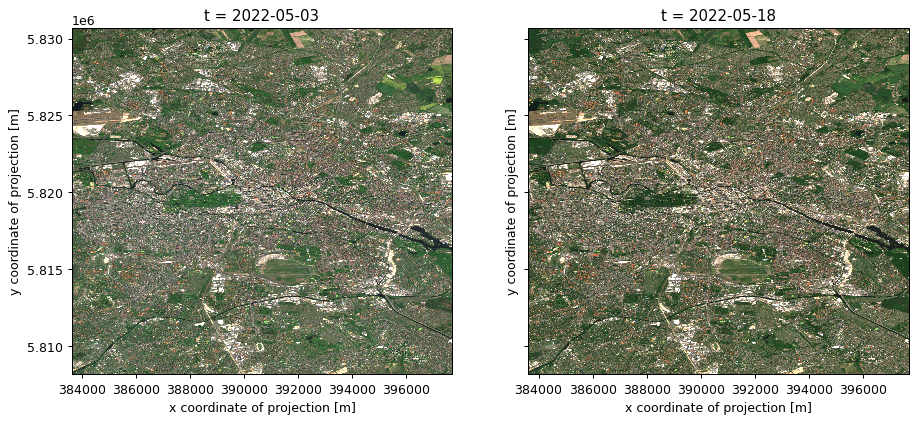

In [62]:
ds1 = xarray.load_dataset("AOI1.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data1 = ds1[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(12, 5), dpi=90, sharey=True)
data1[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data1[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);

### (2) Area of interest 2

In [63]:
# Lake Saimaa
aoi2 = {
    "west": 28.528,  
    "south": 61.178,
    "east": 28.628, 
    "north": 61.378,  
    "crs": "EPSG:4326"
}

In [64]:
cube2 = connection.load_collection(
    "SENTINEL2_L2A",
     bands=["B04", "B03", "B02", "SCL"],  # Red, Green, Blue
     temporal_extent=("2022-05-01", "2022-05-30"),
     spatial_extent=aoi2,
     max_cloud_cover=50,
)

In [65]:
cube2.download("AOI2.nc")

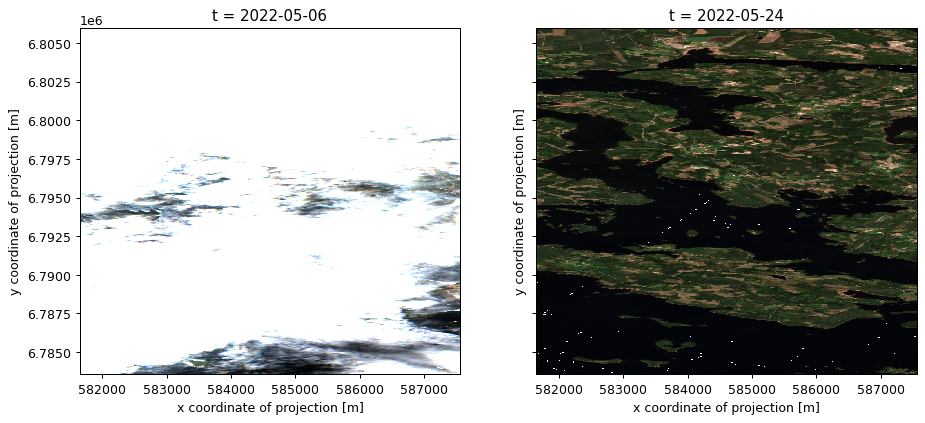

In [66]:
ds2 = xarray.load_dataset("AOI2.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data2 = ds2[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(12, 5), dpi=90, sharey=True)
data2[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data2[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);

After plotting the two areas and analyse observations in different days. 

I can see that Berlin has clear view and no clouds, while Lake Saimaa has one clear view and another view totally covered in clouds

## **Exercise 1.2**

On the same areas of interest, plot atmospheric gas observations of NO$_2$, CO and CH$_4$ from Sentinel-5P from an overpass close to the previous chosen dates and where there's visible data. 
What do you observe?

Zoom out to a sub-continental scale where you can see differences in nearby areas and explain what you observe.

Represent NO$_2$ and CO in molec/cm$^2$.

**Nitrogen dioxide** (NO$_2$) and nitrogen oxide (NO) together are usually referred to as nitrogen oxides. They are important trace gases in the Earth’s atmosphere, present in both the troposphere and the stratosphere. They enter the atmosphere as a result of anthropogenic activities (particularly fossil fuel combustion and biomass burning) and natural processes (such as microbiological processes in soils, wildfires and lightning). Measurements are in mol per square meter (mol/ m$^2$).

**Carbon monoxide** (CO) is an important atmospheric trace gas. In certain urban areas, it is a major atmospheric pollutant. Main sources of CO are combustion of fossil fuels, biomass burning, and atmospheric oxidation of methane and other hydrocarbons. The carbon monoxide total column is measured in mol per square meter (mol/ m$^2$).

**Methane** is, after carbon dioxide, the most important contributor to the anthropogenically (caused by human activity) enhanced greenhouse effect. Measurements are provided in parts per billion (ppb) with a spatial resolution of 7 km x 3.5 km.

Use [Copernicus Browser](https://dataspace.copernicus.eu/browser/) to easly navigate between satellite overpasses from different locations and days.

### (1) Area of interest 1, NO$_2$

In [74]:
NO2_cube1 = connection.load_collection(
    "SENTINEL_5P_L2",
    bands=["NO2"],
    temporal_extent=["2023-01-01", "2023-01-02"],
    spatial_extent=aoi1
)

### (2) Area of interest 1, CO

In [75]:
CO_cube1 = connection.load_collection(
    "SENTINEL_5P_L2",
    bands=["CO"],
    temporal_extent=["2023-01-01", "2023-01-02"],
    spatial_extent=aoi1
)

### (3) Area of interest 1, CH$_4$

In [114]:
CH4_cube1 = connection.load_collection(
    "SENTINEL_5P_L2",
    bands=["CH4"],
    temporal_extent=["2023-01-01", "2023-12-30"],
    spatial_extent=aoi1
)

### (4) Area of interest 2, NO$_2$

In [77]:
NO2_cube2 = connection.load_collection(
    "SENTINEL_5P_L2",
    bands=["NO2"],
    temporal_extent=["2023-01-01", "2023-01-02"],
    spatial_extent=aoi2
)

### (5) Area of interest 2, CO

In [78]:
CO_cube2 = connection.load_collection(
    "SENTINEL_5P_L2",
    bands=["CO"],
    temporal_extent=["2023-01-01", "2023-01-02"],
    spatial_extent=aoi2
)

### (6) Area of interest 2, CH$_4$

In [109]:
CH4_cube2 = connection.load_collection(
    "SENTINEL_5P_L2",
    bands=["CH4"],
    temporal_extent=["2022-01-01", "2022-12-30"],
    spatial_extent=aoi2
)

### Downloading the Data

In [85]:
NO2_cube1.download("NO2_cube1.nc")

In [89]:
NO2_cube2.download("NO2_cube2.nc")

In [88]:
CO_cube1.download("CO_cube1.nc")

In [87]:
CO_cube2.download("CO_cube2.nc")

In [115]:
CH4_cube1.download("CH4_cube1.nc")

In [110]:
CH4_cube2.download("CH4_cube2.nc")

### Plotting the data

<xarray.Dataset>
Dimensions:  (t: 309, x: 4, y: 6)
Coordinates:
  * t        (t) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-28 2023-12-29
  * x        (x) float64 13.32 13.37 13.43 13.48
  * y        (y) float64 52.6 52.56 52.53 52.49 52.46 52.42
Data variables:
    crs      |S1 b''
    CH4      (t, y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform


TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

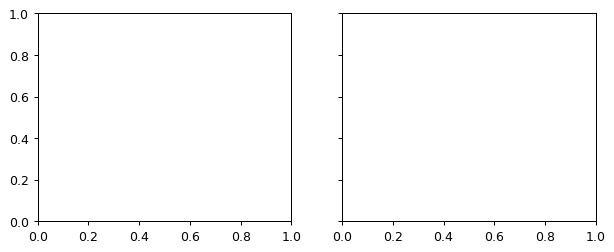

In [117]:
ds = xarray.load_dataset("CH4_cube1.nc")
print(ds)
data = ds[["CH4"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=90, sharey=True)
# print(data)
data[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);

It would take some time to really find an area with all chemicals recorded, as Berlin and Lake Saimaa do not have any records at all whatever the time for Sentinel 5P, and I run out of time so I would leave this exercise empty.

## **Exercise 1.3: Mask clouds**

Combine different images to obtain cloud-free images from the areas of interest of Exercise 1. For this you will need to create a cloud mask using Sentinel-2 scene classification `SCL`band. A simple cloud masking process is described next:
1. First build a binary cloud mask from the SCL values 3 (cloud shadows), 8 (cloud medium probability) and 9 (cloud high probability).
2. Use the `resample_cube_spatial` function to resample the mask  the “SCL” layer has a “ground sample distance” of 20 meter, while it is 10 meter for the “B02”, “B03” and “B04” bands).
3. Apply the cloud mask, and build the composite again.

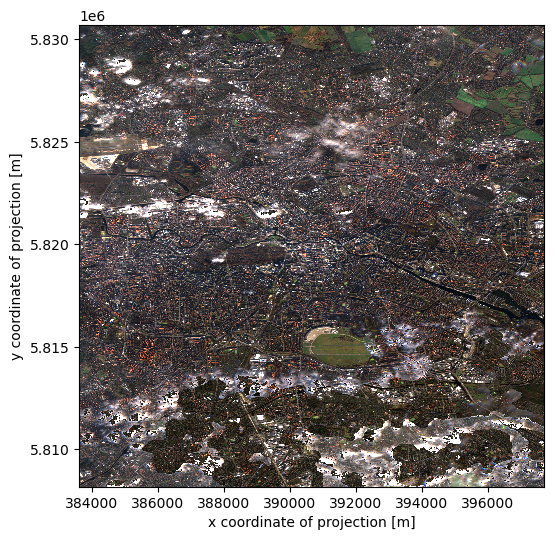

In [8]:
s2_data = connection.load_collection(
    "SENTINEL2_L2A",
    bands=["B04", "B03", "B02", "SCL"],  # Red, Green, Blue, and Scene Classification
    temporal_extent=["2023-01-01", "2023-01-30"],  
    spatial_extent=aoi1,  
    max_cloud_cover=80
)

scl_band = s2_data.band("SCL")
cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)  # Cloud shadows, medium clouds, high clouds

cloud_mask_resampled = cloud_mask.resample_cube_spatial(s2_data, method="near")

s2_data_masked = s2_data.mask(cloud_mask_resampled)
composite = s2_data_masked.max_time()

composite.download("composite_cloud_free.nc")
ds = xarray.load_dataset("composite_cloud_free.nc")
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, ax = plt.subplots(figsize=(6, 6))
data.plot.imshow(vmin=0, vmax=2000, ax=ax)


Now we have image of Berlin without any clouds !

## **Exercise 1.4: NO$_2$ plumes**

In this exercise you will create a small dataset of NO$_2$ plumes. This dataset will be combined with the other students small datasets in the next exercise session, thus you'll end up having a fairly large dataset of plumes. Please follow the guidelines thoroughly so you all end up with a good-quality dataset of NO$_2$ plumes.

1. **Collect plume images:** Collect 20 images from Sentinel-5P satellite data showing clear NO$_2$ plumes originating from power plants. Ensure these plumes are distinct and easily identifiable. Use [Copernicus Browser](https://dataspace.copernicus.eu/browser/) to easly navigate between satellite overpasses from different locations and days. You can use the following databases to find interesting locations: (a) [Database](https://atlas.eia.gov/datasets/eia::power-plants/explore) for thermal power plants in the US; (b) Global Power Plant [Database](https://datasets.wri.org/dataset/globalpowerplantdatabase).
2. **Collect non-plume images:** In addition to plume images, gather 20 images from similar contexts (e.g., near power plants) that do not show any NO$_2$ plumes. These images are crucial for training your model to distinguish between plumes and non-plumes.
**Note:** If you use locations from these databases, please select the locations randomly to ensure you have a high probability of finding plumes different than your classmates.
3. In the Copernicus Browser, once you've located a plume, you can draw a box around it, placing the plume origin around the center (but not necessarily if the box doesn't fit the whole plume), make it roughly 50000 km$^2$ and as squared as possible. Then select download image > Analytical. Image format: TIFF (16-bit); Image resolution: HIGH; Coordinate system: WGS 84; Layers: Raw. Note: Once you select the image resolution, you see the pixel size below, this should be close to 64x64.
4. Uniformize the images: Process all 20 images to have the following specifications:
   - Resolution: Resize all images to a resolution of 64x64 pixels to ensure uniformity.
   - File Format: Save images in PNG format.
5. When you submit your homework, make sure you include a folder with the 20 plumes.

**Example:** [Matimba power station](https://en.wikipedia.org/wiki/Matimba_Power_Station) is the largest direct dry-cooled power station in the world. Once we locate this in Copernicus Browser, we can find a day where a clear plume is visible. We crop an area of approximately 50000 km$^2$ containing the plume and download it as a TIFF image that can be visualized here.

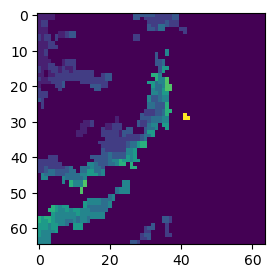

In [11]:
# Open the TIFF file
with rasterio.open("plumes/2 - plume.tiff") as src:
    # Read NO2 data stored in the first band
    no2_data = src.read(1)
    # plot the plume
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(no2_data, cmap='viridis') 
plt.show()

In [118]:
# Open the TIFF file
with rasterio.open('/coursedata/2019-11-07_Matimba.tiff') as src:
    # Read NO2 data stored in the first band
    no2_data = src.read(1)

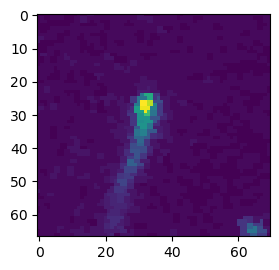

In [119]:
# plot the plume
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(no2_data, cmap='viridis') 
plt.show()

In [120]:
no2_data.shape

(67, 70)

In [121]:
# Calculate the zoom factors for each dimension
zoom_factor_y = 64 / no2_data.shape[0]
zoom_factor_x = 64 / no2_data.shape[1]

# Resize the array
no2_reshaped = zoom(no2_data, (zoom_factor_y, zoom_factor_x))

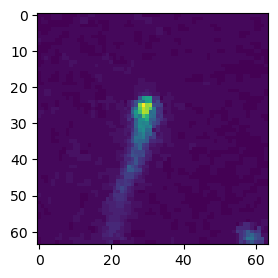

In [122]:
# plot the plume
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(no2_reshaped, cmap='viridis') 
plt.show()

Plumes need to be stored in a consistent way so then they can be easily convined to form a large dataset. Create two folders `/plumes` and `/non-plumes` and storde them accordingly.

In [ ]:
plume_identifier = 'rndm'  # Replace with a random combination of 4 characters.

# Index of the image (1 to 20)
image_index = 1

# Directory to save plume images
output_dir = 'small_dataset_ready/plumes'
# directory to save non-plume images
#output_dir = 'small_dataset_ready/non-plumes'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the file name using the student ID and image index
file_name = f"{plume_identifier}_{image_index}.png"
file_path = os.path.join(output_dir, file_name)

image = Image.fromarray(no2_reshaped)
image.save(file_path, format='PNG')

## **Exercise 1.5: Time-lapse** (Optional)
Create a time-lapse of one of your areas of interests. You can code it yourself using OpenEO or SentinelHub libraries. Alternatively, you can do it directly in Copernicus Browser.